In [ ]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

## Collaborative filtering example

`collab` models use data in a `DataFrame` of user, items, and ratings.

In [ ]:
user,item,title = 'userId','movieId','title'

In [ ]:
path = untar_data(URLs.ML_SAMPLE)
path

PosixPath('/home/jhoward/.fastai/data/movie_lens_sample')

In [ ]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,73,1097,4.0,1255504951
1,561,924,3.5,1172695223
2,157,260,3.5,1291598691
3,358,1210,5.0,957481884
4,130,316,2.0,1138999234


That's all we need to create and train a model:

In [ ]:
data = CollabDataBunch.from_df(ratings, seed=42)

In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(data, n_factors=50, y_range=y_range)

In [ ]:
learn.fit_one_cycle(3, 5e-3)

Total time: 00:04
epoch  train_loss  valid_loss
1      1.600185    0.962681    (00:01)
2      0.851333    0.678732    (00:01)
3      0.660136    0.666290    (00:01)



## Movielens 100k

Let's try with the full Movielens 100k data dataset, available from http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [ ]:
path=Path('data/ml-100k/')

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=[user,item,'rating','timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1', header=None,
                    names=[item, 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
len(ratings)

100000

In [ ]:
rating_movie = ratings.merge(movies[[item, title]])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [ ]:
data = CollabDataBunch.from_df(rating_movie, seed=42, pct_val=0.1, item_name=title)

In [ ]:
data.show_batch()

userId,title,target
588,Twister (1996),3.0
664,"Grifters, The (1990)",4.0
758,"Wings of the Dove, The (1997)",4.0
711,"Empire Strikes Back, The (1980)",5.0
610,"People vs. Larry Flynt, The (1996)",3.0
407,Star Trek: The Wrath of Khan (1982),4.0
649,Independence Day (ID4) (1996),2.0
798,Sabrina (1954),4.0


In [ ]:
y_range = [0,5.5]

In [ ]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


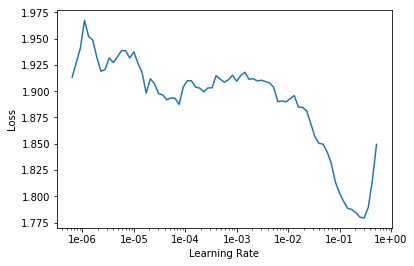

In [ ]:
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(5, 5e-3)

Total time: 00:33
epoch  train_loss  valid_loss
1      0.938132    0.928146    (00:06)
2      0.862458    0.885790    (00:06)
3      0.753191    0.831451    (00:06)
4      0.667046    0.814966    (00:07)
5      0.546363    0.813588    (00:06)



In [ ]:
learn.save('dotprod')

Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91, which corresponds to an MSE of `0.91**2 = 0.83`.

## Interpretation

### Setup

In [ ]:
learn.load('dotprod');

In [ ]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1654, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1654, 1)
)

In [ ]:
g = rating_movie.groupby(title)['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

### Movie bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

In [ ]:
mean_ratings = rating_movie.groupby(title)['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3264),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3241),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2799), 'Island of Dr. Moreau, The (1996)', 2.1578947368421053),
 (tensor(-0.2761), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2703), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2484), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.2413), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2395), 'Striptease (1996)', 2.2388059701492535),
 (tensor(-0.2389), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2346), 'Barb Wire (1996)', 1.9333333333333333),
 (tensor(-0.2325), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2294), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2223), "Joe's Apartment (1996)", 2.2444444444444445),
 (tensor(-0.2218), 'Bio-Dome (1996)', 1.903225806451613),
 (tensor(-0.2117), "Stephen King's T

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6105), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.5817), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5685), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5451), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5350), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.5341), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5330), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.5227), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.5114), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.4800), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.4698), 'Boot, Das (1981)', 4.203980099502488),
 (tensor(0.4589), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4567), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4566), 'Vertigo (1958)', 4.251396648044692),
 (tensor(0.4542), 'Godfather, The (1972)', 4.283292978208232)]

### Movie weights

In [ ]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.0834), 'Chinatown (1974)'),
 (tensor(1.0517), 'Wrong Trousers, The (1993)'),
 (tensor(1.0271), 'Casablanca (1942)'),
 (tensor(1.0193), 'Close Shave, A (1995)'),
 (tensor(1.0093), 'Secrets & Lies (1996)'),
 (tensor(0.9771), 'Lawrence of Arabia (1962)'),
 (tensor(0.9724), '12 Angry Men (1957)'),
 (tensor(0.9660), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9517), 'Ran (1985)'),
 (tensor(0.9460), 'Third Man, The (1949)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2521), 'Jungle2Jungle (1997)'),
 (tensor(-1.1917), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.1746), 'Home Alone 3 (1997)'),
 (tensor(-1.1325), "McHale's Navy (1997)"),
 (tensor(-1.1266), 'Bio-Dome (1996)'),
 (tensor(-1.1115), 'D3: The Mighty Ducks (1996)'),
 (tensor(-1.1062), 'Leave It to Beaver (1997)'),
 (tensor(-1.1051), 'Congo (1995)'),
 (tensor(-1.0934), 'Batman & Robin (1997)'),
 (tensor(-1.0904), 'Flipper (1996)')]

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.8120), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(0.7939), 'Keys to Tulsa (1997)'),
 (tensor(0.7862), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(0.7634), 'Trainspotting (1996)'),
 (tensor(0.7494), 'Brazil (1985)'),
 (tensor(0.7492), 'Heavenly Creatures (1994)'),
 (tensor(0.7446), 'Clockwork Orange, A (1971)'),
 (tensor(0.7420), 'Beavis and Butt-head Do America (1996)'),
 (tensor(0.7271), 'Rosencrantz and Guildenstern Are Dead (1990)'),
 (tensor(0.7249), 'Jude (1996)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.1900), 'Braveheart (1995)'),
 (tensor(-1.0113), 'Raiders of the Lost Ark (1981)'),
 (tensor(-0.9670), 'Titanic (1997)'),
 (tensor(-0.9409), 'Forrest Gump (1994)'),
 (tensor(-0.9151), "It's a Wonderful Life (1946)"),
 (tensor(-0.8721), 'American President, The (1995)'),
 (tensor(-0.8211), 'Top Gun (1986)'),
 (tensor(-0.8207), 'Hunt for Red October, The (1990)'),
 (tensor(-0.8177), 'Sleepless in Seattle (1993)'),
 (tensor(-0.8114), 'Pretty Woman (1990)')]

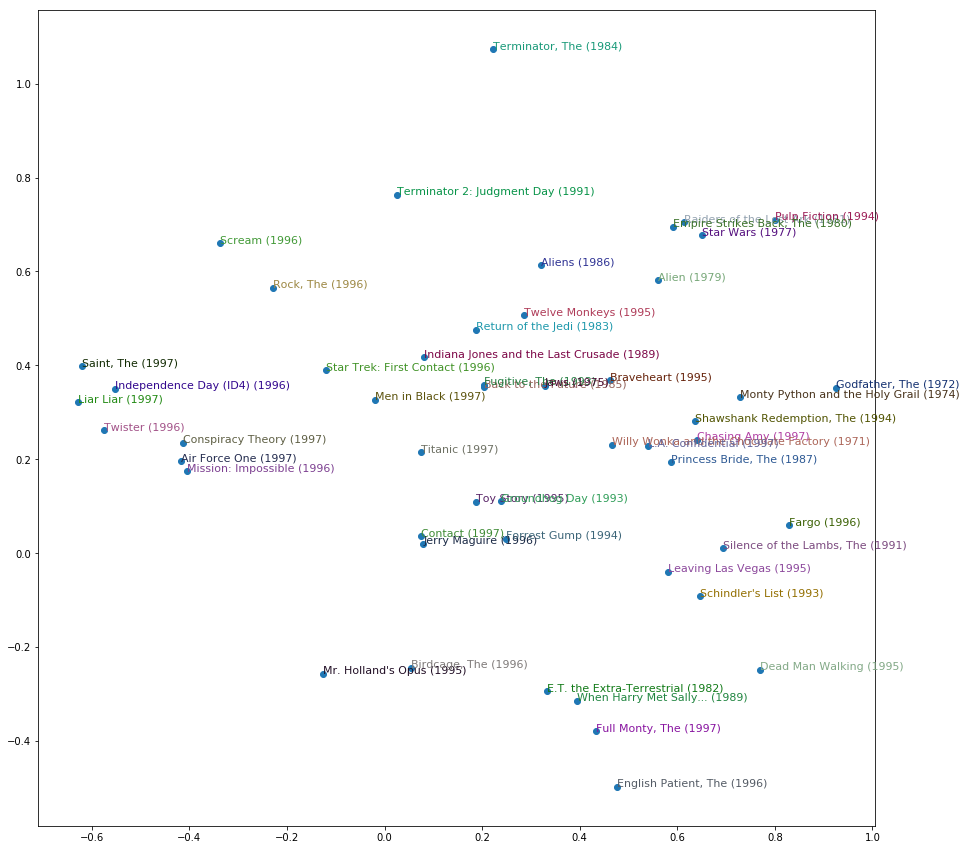

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()